# **Problem 1: Predicting House Price Using Stacked Regression**

In [1]:
import warnings
warnings.filterwarnings("ignore")

 **1. Load the dataset...**

In [ ]:
import pandas as pd

Train = pd.read_csv('train.csv')
Test = pd.read_csv('test.csv')

Train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**2. Identify and remove outliers...**

In [3]:
print("Original Training Dataset Shape:", Train.shape)
print("Original Testing Dataset Shape:", Test.shape)

Original Training Dataset Shape: (1460, 81)
Original Testing Dataset Shape: (1459, 81)


In [4]:
combined_df = pd.concat([Train, Test], axis=0, ignore_index=True)
combined_df.shape


(2919, 81)

In [5]:
print(combined_df.isna().sum().sum())
combined_df = combined_df.dropna(axis=1)
print(combined_df.isna().sum().sum())
combined_df.shape

15707
0


(2919, 47)

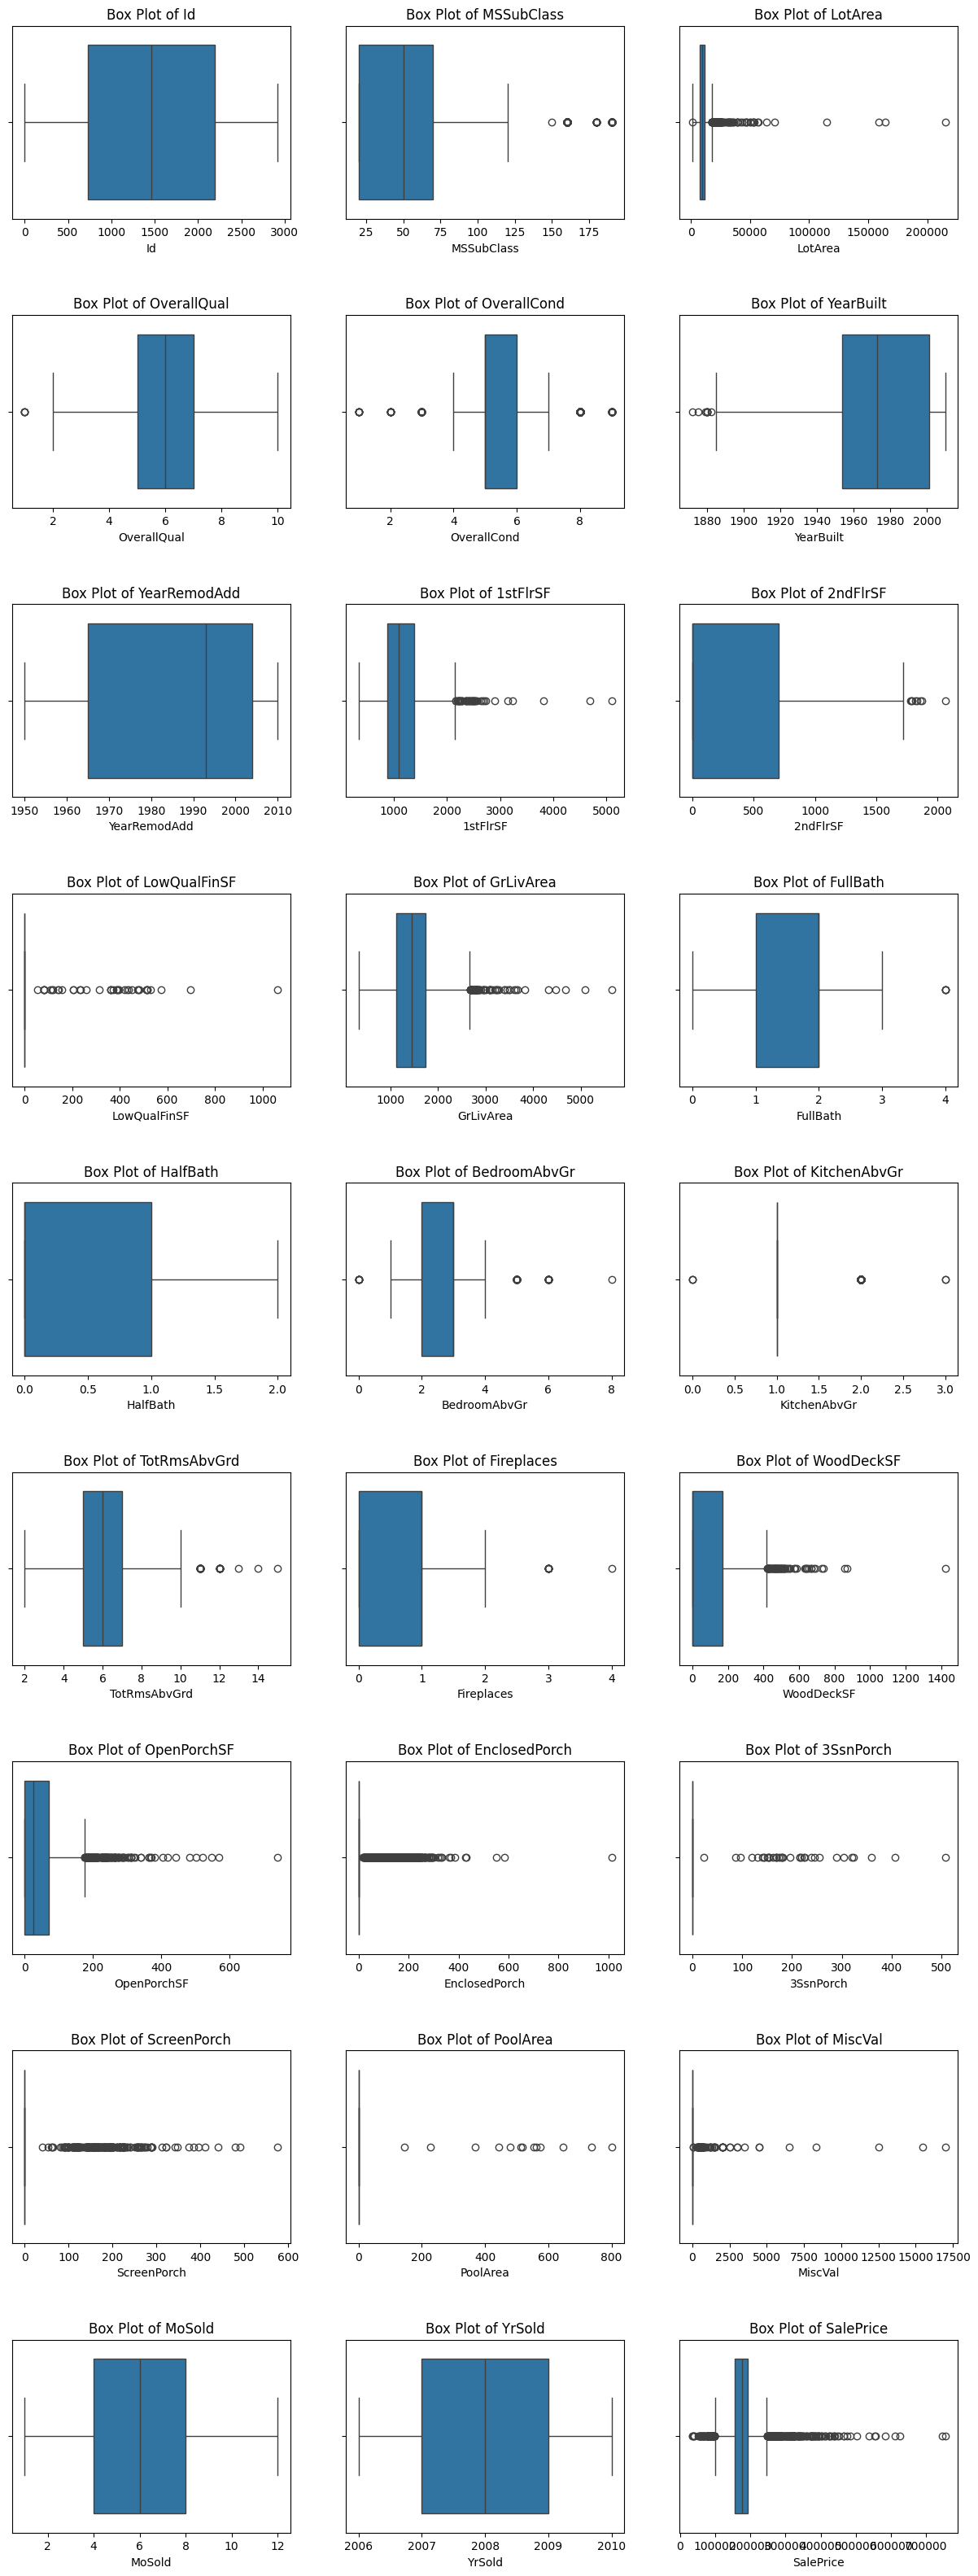

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

num_features = len(combined_df.select_dtypes(include=['float64', 'int64']).columns)

num_cols = 3


num_rows = num_features // num_cols
num_rows += num_features % num_cols


fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 40))
fig.subplots_adjust(hspace=0.5)

for i, feature in enumerate(combined_df.select_dtypes(include=['float64', 'int64']).columns):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    sns.boxplot(x=combined_df.select_dtypes(include=['float64', 'int64'])[feature], ax=ax)
    ax.set_title(f'Box Plot of {feature}')
    ax.set_xlabel(feature)


for i in range(num_features, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.show()

In [10]:
from scipy.stats import zscore



z_scores = zscore(combined_df.select_dtypes(include=['float64', 'int64']))

# typically |z| > 3 is considered an outlier
threshold = 3

# Identify and remove outliers based on the z-score
combined_df_no_outliers = combined_df[(z_scores < threshold).all(axis=1)]

# back into train and test datasets
Train_no_outliers = combined_df_no_outliers.iloc[:len(Train)]
Test_no_outliers = combined_df_no_outliers.iloc[len(Train):]


print(z_scores)

            Id  MSSubClass   LotArea  OverallQual  OverallCond  YearBuilt  \
0    -1.731458    0.067331 -0.217879     0.646183    -0.507284   1.046258   
1    -1.730271   -0.873616 -0.072044    -0.063185     2.188279   0.154764   
2    -1.729084    0.067331  0.137197     0.646183    -0.507284   0.980221   
3    -1.727897    0.302568 -0.078385     0.646183    -0.507284  -1.859351   
4    -1.726711    0.067331  0.518903     1.355551    -0.507284   0.947203   
...        ...         ...       ...          ...          ...        ...   
2914  1.726711    2.419700 -1.043937    -1.481920     1.289758  -0.043346   
2915  1.727897    2.419700 -1.049263    -1.481920    -0.507284  -0.043346   
2916  1.729084   -0.873616  1.246808    -0.772552     1.289758  -0.373528   
2917  1.730271    0.655424  0.034605    -0.772552    -0.507284   0.683057   
2918  1.731458    0.067331 -0.068620     0.646183    -0.507284   0.716075   

      YearRemodAdd  1stFlrSF  2ndFlrSF  LowQualFinSF  ...  WoodDeckSF  \
0 

In [11]:
print("Training Dataset Shape After Removing Outliers:", Train_no_outliers.shape)
print("Testing Dataset Shape After Removing Outliers:", Test_no_outliers.shape)
combined_df_no_outliers.shape

Training Dataset Shape After Removing Outliers: (1460, 47)
Testing Dataset Shape After Removing Outliers: (840, 47)


(2300, 47)

In [12]:
test = Test_no_outliers
train = Train_no_outliers

**3. Normalize the target column...**

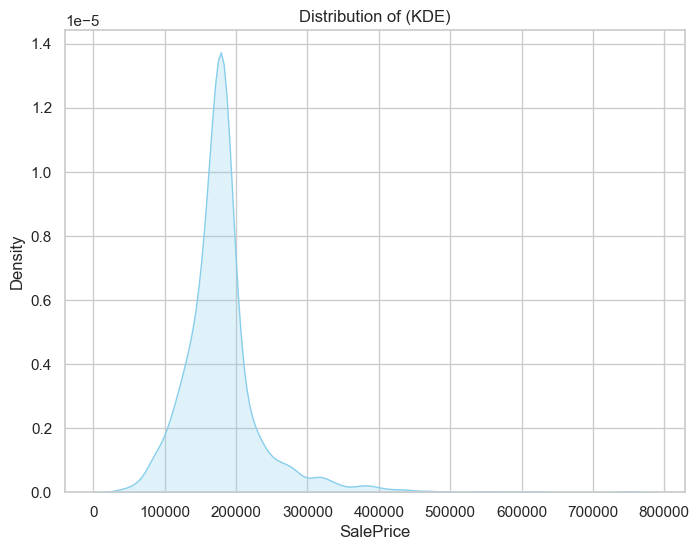

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn plots
sns.set(style="whitegrid")


plt.figure(figsize=(8, 6))
sns.kdeplot(combined_df['SalePrice'], color='skyblue', shade=True)
plt.title('Distribution of (KDE)')
plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.show()

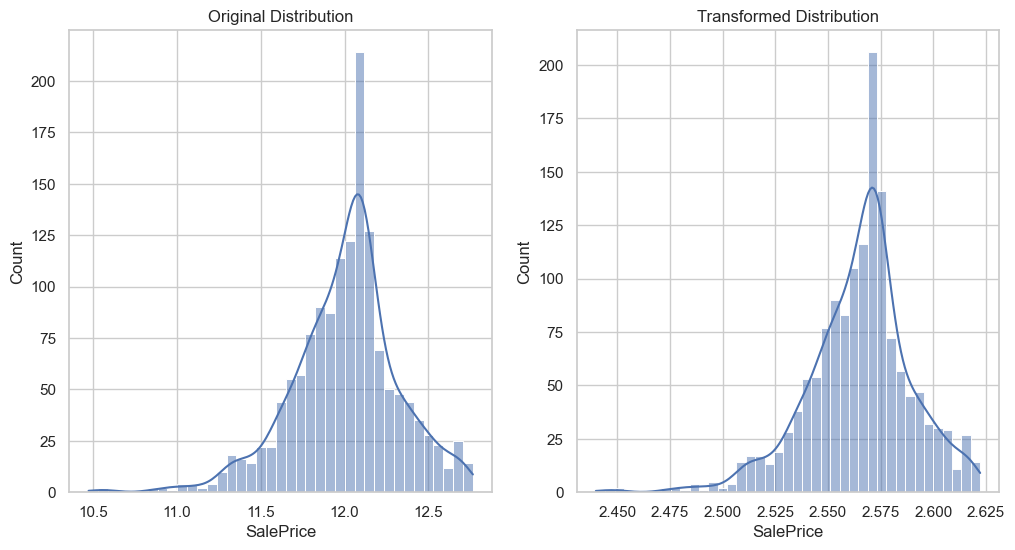

In [14]:
import numpy as np

# Apply logarithmic transformation to the target column (for example, 'SalePrice')
train['SalePrice'] = np.log1p(train['SalePrice'])

# Check the distribution after the transformation
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the original and transformed distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(train['SalePrice'], kde=True)
plt.title('Original Distribution')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(train['SalePrice']), kde=True)
plt.title('Transformed Distribution')

plt.show()

**4. Preprocess the dataset...**

In [15]:
tmp_combine = pd.concat([train, test], axis=0, ignore_index=True)

In [16]:
categorical_features = []
numerical_features = []

for column in tmp_combine.columns:

    unique_values = tmp_combine[column].nunique()
    print(unique_values)
    if unique_values <= 18:
        categorical_features.append(column)
    else:
        numerical_features.append(column)

print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

2300
14
1584
2
4
4
5
3
25
9
6
5
7
10
8
108
61
6
4
4
5
6
5
5
2
942
519
4
1086
4
2
6
2
10
3
3
311
195
115
2
65
1
22
12
5
6
1699
Categorical Features: ['MSSubClass', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'LowQualFinSF', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'PavedDrive', '3SsnPorch', 'PoolArea', 'MoSold', 'YrSold', 'SaleCondition']
Numerical Features: ['Id', 'LotArea', 'Neighborhood', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'MiscVal', 'SalePrice']


### **ONE HOT ENCODING**

In [17]:

tmp_combine = pd.get_dummies(tmp_combine, columns=categorical_features, drop_first=True)


In [18]:
tmp_combine = tmp_combine.drop("Neighborhood", axis=1) # categorical with too much variety
tmp_combine = tmp_combine.drop("Id", axis=1) # no meaning
tmp_combine

,LotArea,YearBuilt,YearRemodAdd,1stFlrSF,2ndFlrSF,GrLivArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,...,MoSold_12,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,8450,2003,2003,856,854,1710,0,61,0,0,...,False,False,True,False,False,False,False,False,True,False
1,9600,1976,1976,1262,0,1262,298,0,0,0,...,False,True,False,False,False,False,False,False,True,False
2,11250,2001,2002,920,866,1786,0,42,0,0,...,False,False,True,False,False,False,False,False,True,False
3,14260,2000,2000,1145,1053,2198,192,84,0,0,...,True,False,True,False,False,False,False,False,True,False
4,10084,2004,2005,1694,0,1694,255,57,0,0,...,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,1526,1970,1970,546,546,1092,0,34,0,0,...,False,False,False,False,False,False,False,False,True,False
2296,1936,1970,1970,546,546,1092,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
2297,1894,1970,1970,546,546,1092,0,24,0,0,...,False,False,False,False,False,False,False,False,False,False
2298,10441,1992,1992,970,0,970,80,32,0,0,...,False,False,False,False,False,False,False,False,True,False


In [19]:
numerical_features.remove("Neighborhood")
numerical_features.remove("Id")
numerical_features

['LotArea',
 'YearBuilt',
 'YearRemodAdd',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'ScreenPorch',
 'MiscVal',
 'SalePrice']

In [20]:
train = tmp_combine.iloc[:len(train)]
test = tmp_combine.iloc[len(train):]

### **Feature Scaling**

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train[numerical_features] = scaler.fit_transform(train[numerical_features])
test[numerical_features] = scaler.transform(test[numerical_features])

**5. Train models...**

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor


In [23]:
X_train = train.copy()
y_train = X_train.pop("SalePrice")

X_test = test.copy()
y_test = X_test.pop("SalePrice")

In [24]:
X_train.shape

(1460, 152)

In [25]:
y_train.shape

(1460,)

In [26]:
X_train

,LotArea,YearBuilt,YearRemodAdd,1stFlrSF,2ndFlrSF,GrLivArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,...,MoSold_12,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.215203,1.000867,0.852729,-0.748394,1.366295,0.694566,-0.807595,0.366145,-0.350365,-0.223808,...,False,False,True,False,False,False,False,False,True,False
1,0.087644,0.071177,-0.448346,0.471691,-0.779874,-0.362257,1.910733,-0.776223,-0.350365,-0.223808,...,False,True,False,False,False,False,False,False,True,False
2,0.522164,0.932001,0.804541,-0.556065,1.396452,0.873848,-0.807595,0.010326,-0.350365,-0.223808,...,False,False,True,False,False,False,False,False,True,False
3,1.314833,0.897568,0.708165,0.120090,1.866398,1.845748,0.943811,0.796874,-0.350365,-0.223808,...,True,False,True,False,False,False,False,False,True,False
4,0.215103,1.035300,0.949105,1.769909,-0.779874,0.656822,1.518491,0.291236,-0.350365,-0.223808,...,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,-0.136199,0.828703,0.611789,-0.532024,1.341165,0.840823,0.560691,1.021602,-0.350365,-0.223808,...,False,False,False,True,False,False,False,False,True,False
1456,0.387594,0.966434,0.756353,1.018625,-0.779874,0.067077,0.505960,-0.027129,-0.350365,-0.223808,...,False,False,False,True,False,False,False,False,True,False
1457,0.500043,0.932001,0.756353,1.162872,-0.779874,0.180308,-0.807595,1.358694,-0.350365,5.175582,...,False,False,False,True,False,False,False,True,False,False
1458,1.843894,0.140043,-0.351970,-0.595132,-0.779874,-1.199694,-0.150818,-0.776223,-0.350365,-0.223808,...,False,False,False,True,False,False,False,False,True,False


**6. Evaluate model performance...**

In [27]:
# Parameters for Lasso Regression
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

# Parameters for Elastic Net Regression
elasticnet_params = {'alpha': [0.001, 0.01, 0.1, 1, 10],
                    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}

# Parameters for Kernel Ridge Regression
kernel_ridge_params = {'alpha': [0.1, 1, 10],
                       'kernel': ['linear', 'rbf']}

# Parameters for Gradient Boosting Regression
gradient_boosting_params = {'n_estimators': [50, 100, 150],
                            'learning_rate': [0.01, 0.1, 0.2],
                            'max_depth': [3, 4, 5]}


In [29]:
# Lasso Regression
lasso_grid = GridSearchCV(Lasso(), param_grid=lasso_params, cv=5)
lasso_grid.fit(X_train, y_train)
lasso_best_params = lasso_grid.best_params_

# Elastic Net Regression
elasticnet_grid = GridSearchCV(ElasticNet(), param_grid=elasticnet_params, cv=5)
elasticnet_grid.fit(X_train, y_train)
elasticnet_best_params = elasticnet_grid.best_params_

# Kernel Ridge Regression
kernel_ridge_grid = GridSearchCV(KernelRidge(), param_grid=kernel_ridge_params, cv=5)
kernel_ridge_grid.fit(X_train, y_train)
kernel_ridge_best_params = kernel_ridge_grid.best_params_

# Gradient Boosting Regression
gradient_boosting_grid = GridSearchCV(GradientBoostingRegressor(), param_grid=gradient_boosting_params, cv=5)
gradient_boosting_grid.fit(X_train, y_train)
gradient_boosting_best_params = gradient_boosting_grid.best_params_


In [30]:
print("Best Parameters: ", lasso_grid.best_params_)
print("Best Estimator: ", lasso_grid.best_estimator_)


Best Parameters:  {'alpha': 1}
Best Estimator:  Lasso(alpha=1)


In [31]:
print("Best Parameters: ", lasso_grid.best_params_)
print("Best Estimator: ", lasso_grid.best_estimator_)


Best Parameters:  {'alpha': 1}
Best Estimator:  Lasso(alpha=1)


In [32]:
results = lasso_grid.cv_results_
results

{'mean_fit_time': array([0.10204496, 0.02287865, 0.01614032, 0.01332088, 0.01920705]),
 'std_fit_time': array([0.00756346, 0.00373402, 0.00450329, 0.00839084, 0.00384116]),
 'mean_score_time': array([0.        , 0.0021946 , 0.00160112, 0.00444603, 0.        ]),
 'std_score_time': array([0.        , 0.00319933, 0.00320225, 0.00687881, 0.        ]),
 'param_alpha': masked_array(data=[0.001, 0.01, 0.1, 1.0, 10.0],
              mask=[False, False, False, False, False],
        fill_value=1e+20),
 'params': [{'alpha': 0.001},
  {'alpha': 0.01},
  {'alpha': 0.1},
  {'alpha': 1},
  {'alpha': 10}],
 'split0_test_score': array([ 7.79054100e-01,  7.66374076e-01,  6.81215028e-01, -1.41094368e-04,
        -1.41094368e-04]),
 'split1_test_score': array([ 0.78364494,  0.7517687 ,  0.67065441, -0.01483497, -0.01483497]),
 'split2_test_score': array([ 0.75954242,  0.73194087,  0.6366113 , -0.0108969 , -0.0108969 ]),
 'split3_test_score': array([ 7.27339358e-01,  7.09774144e-01,  6.37419845e-01, -3.02

In [33]:
from sklearn.model_selection import cross_val_score

lasso_grid_mse_scores = cross_val_score(lasso_grid.best_estimator_, X_test, y_test, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-lasso_grid_mse_scores)  # Convert back to positive values

print("lasso_grid Cross-Validation RMSE Scores: ", rmse_scores)
print("lasso_grid Mean RMSE: ", np.mean(rmse_scores))


elasticnet_grid_mse_scores = cross_val_score(elasticnet_grid.best_estimator_, X_test, y_test, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-elasticnet_grid_mse_scores)  # Convert back to positive values

print("elasticnet_grid Cross-Validation RMSE Scores: ", rmse_scores)
print("elasticnet_grid Mean RMSE: ", np.mean(rmse_scores))


kernel_ridge_grid_mse_scores = cross_val_score(kernel_ridge_grid.best_estimator_, X_test, y_test, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-kernel_ridge_grid_mse_scores)  # Convert back to positive values

print("kernel_ridge_grid Cross-Validation RMSE Scores: ", rmse_scores)
print("kernel_ridge_grid Mean RMSE: ", np.mean(rmse_scores))



gradient_boosting_grid_mse_scores = cross_val_score(gradient_boosting_grid.best_estimator_, X_test, y_test, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-gradient_boosting_grid_mse_scores)  # Convert back to positive values

print("gradient_boosting_grid Cross-Validation RMSE Scores: ", rmse_scores)
print("gradient_boosting_grid Mean RMSE: ", np.mean(rmse_scores))

lasso_grid Cross-Validation RMSE Scores:  [ 6634.38701797   336.46536341   149.55741912 10793.79428715
   410.0367632 ]
lasso_grid Mean RMSE:  3664.848170171168
elasticnet_grid Cross-Validation RMSE Scores:  [21434.42264315 24081.53547292 20390.10749371 21955.93903086
 23552.06317577]
elasticnet_grid Mean RMSE:  22282.813563283515
kernel_ridge_grid Cross-Validation RMSE Scores:  [62466.51322631 43511.5783172  34761.23047377 43133.78773823
 50546.26909601]
kernel_ridge_grid Mean RMSE:  46883.87577030273
gradient_boosting_grid Cross-Validation RMSE Scores:  [33557.32857383 33307.5367292  27938.10088636 34626.30283382
 38784.79243522]
gradient_boosting_grid Mean RMSE:  33642.81229168429


In [34]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate R-squared (R2) and MSE for Lasso Regression model
lasso_predictions = lasso_grid.best_estimator_.predict(X_test)
lasso_r2 = r2_score(y_test, lasso_predictions)
lasso_mse = mean_squared_error(y_test, lasso_predictions)
print("Lasso Regression Model - MSE: {:.2f}".format(lasso_mse))
print("Lasso Regression Model - R2 Score: {:.2f}".format(lasso_r2))

# Calculate R-squared (R2) and MSE for Elastic Net model
elasticnet_predictions = elasticnet_grid.best_estimator_.predict(X_test)
elasticnet_r2 = r2_score(y_test, elasticnet_predictions)
elasticnet_mse = mean_squared_error(y_test, elasticnet_predictions)
print("Elastic Net Model - MSE: {:.2f}".format(elasticnet_mse))
print("Elastic Net Model - R2 Score: {:.2f}".format(elasticnet_r2))

# Calculate R-squared (R2) and MSE for Kernel Ridge model
kernel_ridge_predictions = kernel_ridge_grid.best_estimator_.predict(X_test)
kernel_ridge_r2 = r2_score(y_test, kernel_ridge_predictions)
kernel_ridge_mse = mean_squared_error(y_test, kernel_ridge_predictions)
print("Kernel Ridge Model - MSE: {:.2f}".format(kernel_ridge_mse))
print("Kernel Ridge Model - R2 Score: {:.2f}".format(kernel_ridge_r2))

# Calculate R-squared (R2) and MSE for Gradient Boosting model
gradient_boosting_predictions = gradient_boosting_grid.best_estimator_.predict(X_test)
gradient_boosting_r2 = r2_score(y_test, gradient_boosting_predictions)
gradient_boosting_mse = mean_squared_error(y_test, gradient_boosting_predictions)
print("Gradient Boosting Model - MSE: {:.2f}".format(gradient_boosting_mse))
print("Gradient Boosting Model - R2 Score: {:.2f}".format(gradient_boosting_r2))


Lasso Regression Model - MSE: 312766057900.95
Lasso Regression Model - R2 Score: -153.09
Elastic Net Model - MSE: 312766057900.95
Elastic Net Model - R2 Score: -153.09
Kernel Ridge Model - MSE: 312766019879.32
Kernel Ridge Model - R2 Score: -153.09
Gradient Boosting Model - MSE: 312766046018.80
Gradient Boosting Model - R2 Score: -153.09


In [35]:
print("Best Parameters: ", elasticnet_grid.best_params_)
print("Best Estimator: ", elasticnet_grid.best_estimator_)

Best Parameters:  {'alpha': 1, 'l1_ratio': 0.7}
Best Estimator:  ElasticNet(alpha=1, l1_ratio=0.7)


**8. Train a Stacked Regression model...**

In [36]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, ElasticNet
import numpy as np

# Define base models
base_models = [
    ('lasso', Lasso(alpha=0.1)),
    ('elasticnet', ElasticNet(alpha=0.1, l1_ratio=0.5)),
    ('random_forest', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gradient_boosting', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
]


In [37]:
# Define meta-model
meta_model = Lasso(alpha=0.1)


In [38]:
# Create a list to hold the predictions from base models for the test set
base_models_test_predictions = []


In [39]:
# Generate predictions from base models for the test set
for name, model in base_models:
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    base_models_test_predictions.append(preds)

In [40]:
# Prepare the meta-features for the test set
meta_features_test = np.array(base_models_test_predictions).T

In [41]:
# Train the meta-model on the entire training set (X_train and y_train)
# Generate predictions from base models for the training set for meta-model training
base_models_train_predictions = []
for name, model in base_models:
    model.fit(X_train, y_train)
    preds = model.predict(X_train)
    base_models_train_predictions.append(preds)

In [42]:
# Prepare the meta-features for training the meta-model (training set)
meta_features_train = np.array(base_models_train_predictions).T

In [43]:
# Train the meta-model on the meta-features (training set)
meta_model.fit(meta_features_train, y_train)

Lasso(alpha=0.1)

In [44]:
# Make predictions using the meta-model on the test set
stacked_predictions = meta_model.predict(meta_features_test)

**9. Report the MSE and R²...**

In [45]:
from sklearn.metrics import mean_squared_error, r2_score


stacked_mse = mean_squared_error(y_test, stacked_predictions)


stacked_r2 = r2_score(y_test, stacked_predictions)

print("Stacked Regression Model - MSE: {:.2f}".format(stacked_mse))
print("Stacked Regression Model - R2 Score: {:.2f}".format(stacked_r2))


Stacked Regression Model - MSE: 312766028378.00
Stacked Regression Model - R2 Score: -153.09


In [46]:
stacked_rmse = np.sqrt(stacked_mse)
stacked_rmse

np.float64(559254.886771677)

In [47]:
-elasticnet_grid_mse_scores


array([4.59434474e+08, 5.79920351e+08, 4.15756484e+08, 4.82063259e+08,
       5.54699680e+08])

In [48]:
stacked_mse

np.float64(312766028378.0012)

In [49]:
-elasticnet_grid_mse_scores > stacked_mse

array([False, False, False, False, False])

In [50]:
print(np.mean(elasticnet_grid_mse_scores))

-498374849.3892803


In [51]:
kernel_ridge_grid_mse_scores
print(np.mean(kernel_ridge_grid_mse_scores))

-2283822966.1058846


In [52]:
lasso_grid_mse_scores
print(np.mean(lasso_grid_mse_scores))

-32164958.545431864
